In [ ]:
## check gpu usage:
# nvidia-smi

In [1]:
import os
import cv2
import random
import time
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from xml.etree import ElementTree
import numpy as np
import skimage

from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

Using TensorFlow backend.


In [2]:
max_size = 128  # the max image dimension (either width or height)
class_category_list = ['router', 'ceiling fan', 'tv', 'laptop']


In [3]:
def resize_img(img3d, max_d=max_size, ismasks=True):
    w, h, c = img3d.shape
    scale_factor = max(w/max_d, h/max_d, 1)
    w_new, h_new = int(w/scale_factor), int(h/scale_factor)

    if ismasks:
        result = []
        for i in range(c):
            result.append(cv2.resize(img3d[:, :, i], dsize=(h_new, w_new), interpolation=cv2.INTER_CUBIC))
        result = np.stack(result, axis=2)
    else:
        result = cv2.resize(img3d, dsize=(h_new, w_new), interpolation=cv2.INTER_CUBIC)
    return result


# to be used if the label is in xml format
class DatasetXML(Dataset):

    def add_class_info(self, class_category_list):
        for i, cl_cat in enumerate(class_category_list):
            self.add_class("dataset", i+1, cl_cat)

    # load the dataset definitions
    def load_dataset(self, dataset_dir, img_name_list, max_d):
        self.max_d = max_d

        # define data locations
        images_dir = os.path.join(dataset_dir, 'images')
        annotations_dir = os.path.join(dataset_dir, 'annots')
        # find all images
        for filename in img_name_list:
            image_id = filename.split('.')[0]
            img_path = os.path.join(images_dir, filename)
            ann_path = os.path.join(annotations_dir, image_id+'.xml')
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        objects = []
        for obj in root.findall('.//object'):
            objname = obj.find('name').text
            box = obj.find('.//bndbox')
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            objects.append([objname, coors])
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return objects, width, height

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        objects, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = np.zeros([h, w, len(objects)], dtype='uint8')
        # create masks
        class_ids = []
        for i in range(len(objects)):
            cl_name, box = objects[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(cl_name))

        masks = resize_img(masks, self.max_d, ismasks=True)   #############

        return masks, np.asarray(class_ids, dtype='int32')

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]

        image = resize_img(image, self.max_d, ismasks=False)   #############

        return image

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [4]:
trainset = DatasetXML()
trainset.add_class_info(class_category_list)
testset = DatasetXML()
testset.add_class_info(class_category_list)

print(testset.class_info)
print(trainset.class_info)

[{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'dataset', 'id': 1, 'name': 'router'}, {'source': 'dataset', 'id': 2, 'name': 'ceiling fan'}, {'source': 'dataset', 'id': 3, 'name': 'tv'}, {'source': 'dataset', 'id': 4, 'name': 'laptop'}]
[{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'dataset', 'id': 1, 'name': 'router'}, {'source': 'dataset', 'id': 2, 'name': 'ceiling fan'}, {'source': 'dataset', 'id': 3, 'name': 'tv'}, {'source': 'dataset', 'id': 4, 'name': 'laptop'}]


## Load datasets

### router

In [5]:
dataset_dir = os.path.join(os.getcwd(), 'data', 'router')
all_imgs = os.listdir(os.path.join(dataset_dir, 'images'))
train_test_ratio = 0.9
random.shuffle(all_imgs)
train_imgs = all_imgs[:int(train_test_ratio*len(all_imgs))]
test_imgs = all_imgs[int(train_test_ratio*len(all_imgs)):]
print(len(train_imgs), len(test_imgs), len(all_imgs), len(train_imgs) / len(all_imgs))

trainset.load_dataset(dataset_dir, train_imgs, max_size)
trainset.prepare()
print('Train: %d' % len(trainset.image_ids))

testset.load_dataset(dataset_dir, test_imgs, max_size)
testset.prepare()
print('Test: %d' % len(testset.image_ids))

83 10 93 0.8924731182795699
Train: 83
Test: 10


### ceiling fan

In [6]:
dataset_dir = os.path.join(os.getcwd(), 'data', 'ceilingfan')
all_imgs = os.listdir(os.path.join(dataset_dir, 'images'))
train_test_ratio = 0.9
random.shuffle(all_imgs)
train_imgs = all_imgs[:int(train_test_ratio*len(all_imgs))]
test_imgs = all_imgs[int(train_test_ratio*len(all_imgs)):]
print(len(train_imgs), len(test_imgs), len(all_imgs), len(train_imgs) / len(all_imgs))

trainset.load_dataset(dataset_dir, train_imgs, max_size)
trainset.prepare()
print('Train: %d' % len(trainset.image_ids))

testset.load_dataset(dataset_dir, test_imgs, max_size)
testset.prepare()
print('Test: %d' % len(testset.image_ids))


90 10 100 0.9
Train: 173
Test: 20


### Others

In [7]:
# load router data -------
dataset_dir = os.path.join(os.getcwd(), 'data', 'others')
all_imgs = os.listdir(os.path.join(dataset_dir, 'images'))
train_test_ratio = 0.9
random.shuffle(all_imgs)
train_imgs = all_imgs[:int(train_test_ratio*len(all_imgs))]
test_imgs = all_imgs[int(train_test_ratio*len(all_imgs)):]
print(len(train_imgs), len(test_imgs), len(all_imgs), len(train_imgs) / len(all_imgs))

trainset.load_dataset(dataset_dir, train_imgs, max_size)
trainset.prepare()
print('Train: %d' % len(trainset.image_ids))

testset.load_dataset(dataset_dir, test_imgs, max_size)
testset.prepare()
print('Test: %d' % len(testset.image_ids))

88 10 98 0.8979591836734694
Train: 261
Test: 30


## Check data

In [8]:
image_id =1

# load an image
image = trainset.load_image(image_id)
print(image.shape)

# load image mask
mask, class_ids = testset.load_mask(image_id)
print(mask.shape)

(87, 128, 3)
(85, 128, 1)


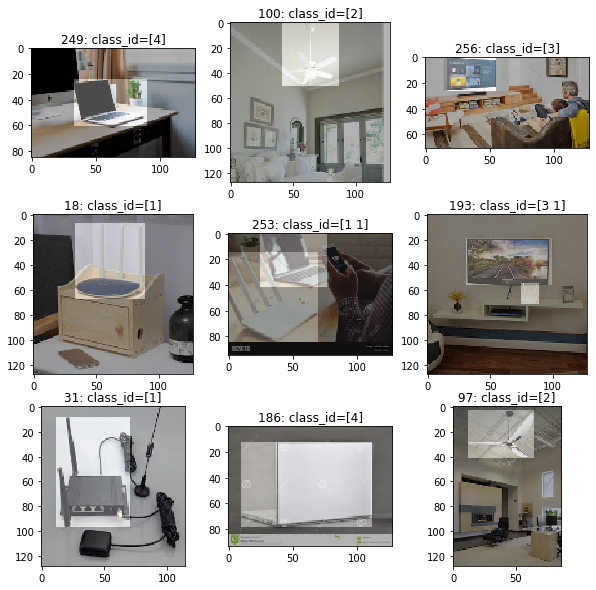

In [9]:
# plot first few images

sample_imgs = random.sample(list(range(len(trainset.image_info))), 9)
plt.figure(figsize=(10,10))
for i, img_id in enumerate(sample_imgs):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    image = trainset.load_image(img_id)
    plt.imshow(image)
    # plot all masks
    mask, class_ids = trainset.load_mask(img_id)
    for j in range(mask.shape[2]):
        plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
    plt.title("{}: class_id={}".format(img_id, class_ids))
# show the figure
plt.show()

# Train

In [10]:
# define a configuration for the model
class RouterConfig(Config):
    # Give the configuration a recognizable name
    NAME = "new_multiclass_cfg"
    # Number of classes (background + other classes)
    NUM_CLASSES = 1 + len(class_category_list)
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100  # 131

# prepare config
config = RouterConfig()

# define the model
model = MaskRCNN(mode='training', model_dir=os.getcwd(), config=config)

# load weights (mscoco)
#model_dir = os.path.join(os.getcwd(), 'mask_rcnn_coco.h5')

model_dir = os.path.join(os.getcwd(), 'new_multiclass_cfg20191024T1510', 'mask_rcnn_new_multiclass_cfg_0047.h5')

model.load_weights(model_dir, by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

model.train(trainset, testset, learning_rate=config.LEARNING_RATE, epochs=100, layers='heads')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Re-starting from epoch 47

Starting at epoch 47. LR=0.001

Checkpoint Path: /tf/new_multiclass_cfg20191024T1510/mask_rcnn_new_multiclass_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_clas

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 48/100


ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

 12/100 [==>...........................] - ETA: 3:56 - loss: 2.2881 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.2271 - mrcnn_bbox_loss: 0.6406 - mrcnn_mask_loss: 1.3802

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

 70/100 [====================>.........] - ETA: 23s - loss: 1.0892 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0689 - mrcnn_class_loss: 0.1159 - mrcnn_bbox_loss: 0.3911 - mrcnn_mask_loss: 0.5108

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

 73/100 [====================>.........] - ETA: 20s - loss: 1.0692 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0693 - mrcnn_class_loss: 0.1139 - mrcnn_bbox_loss: 0.3843 - mrcnn_mask_loss: 0.4991

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

 75/100 [=====================>........] - ETA: 18s - loss: 1.0625 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0704 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.3825 - mrcnn_mask_loss: 0.4938

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

 99/100 [============================>.] - ETA: 0s - loss: 0.9337 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0730 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.3324 - mrcnn_mask_loss: 0.4264

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2251: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 134s 1s/step - loss: 0.9279 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0725 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.3305 - mrcnn_mask_loss: 0.4238 - val_loss: 0.4474 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 0.0419 - val_mrcnn_class_loss: 0.0465 - val_mrcnn_bbox_loss: 0.1623 - val_mrcnn_mask_loss: 0.1950
Epoch 49/100
100/100 [==============================] - 63s 633ms/step - loss: 0.4042 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.1349 - mrcnn_mask_loss: 0.1555 - val_loss: 0.3929 - val_rpn_class_loss: 0.0019 - val_rpn_bbox_loss: 0.0865 - val_mrcnn_class_loss: 0.0268 - val_mrcnn_bbox_loss: 0.1455 - val_mrcnn_mask_loss: 0.1322
Epoch 50/100
100/100 [==============================] - 65s 649ms/step - loss: 0.3161 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0491 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.1181 - val_loss: 0.3209 - val_rpn_class_loss

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

100/100 [==============================] - 65s 650ms/step - loss: 0.2115 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1006 - val_loss: 0.2835 - val_rpn_class_loss: 0.0022 - val_rpn_bbox_loss: 0.0577 - val_mrcnn_class_loss: 0.0185 - val_mrcnn_bbox_loss: 0.0856 - val_mrcnn_mask_loss: 0.1194
Epoch 57/100
 82/100 [=======================>......] - ETA: 6s - loss: 0.1817 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0375 - mrcnn_mask_loss: 0.0948

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

100/100 [==============================] - 64s 643ms/step - loss: 0.1842 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0373 - mrcnn_mask_loss: 0.0956 - val_loss: 0.2856 - val_rpn_class_loss: 0.0018 - val_rpn_bbox_loss: 0.0601 - val_mrcnn_class_loss: 0.0171 - val_mrcnn_bbox_loss: 0.0779 - val_mrcnn_mask_loss: 0.1287
Epoch 58/100
100/100 [==============================] - 65s 655ms/step - loss: 0.1964 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0346 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.0956 - val_loss: 0.2958 - val_rpn_class_loss: 0.0018 - val_rpn_bbox_loss: 0.0839 - val_mrcnn_class_loss: 0.0181 - val_mrcnn_bbox_loss: 0.0719 - val_mrcnn_mask_loss: 0.1202
Epoch 59/100
  4/100 [>.............................] - ETA: 37s - loss: 0.2022 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0445 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1064

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

100/100 [==============================] - 64s 639ms/step - loss: 0.1953 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.0993 - val_loss: 0.3004 - val_rpn_class_loss: 0.0023 - val_rpn_bbox_loss: 0.0690 - val_mrcnn_class_loss: 0.0195 - val_mrcnn_bbox_loss: 0.0800 - val_mrcnn_mask_loss: 0.1297
Epoch 60/100
 41/100 [===========>..................] - ETA: 22s - loss: 0.1888 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0345 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.0978

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

100/100 [==============================] - 64s 643ms/step - loss: 0.1865 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0955 - val_loss: 0.3309 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 0.0791 - val_mrcnn_class_loss: 0.0200 - val_mrcnn_bbox_loss: 0.0992 - val_mrcnn_mask_loss: 0.1308
Epoch 61/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1767 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0961

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

100/100 [==============================] - 65s 647ms/step - loss: 0.1770 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0963 - val_loss: 0.2920 - val_rpn_class_loss: 0.0027 - val_rpn_bbox_loss: 0.0521 - val_mrcnn_class_loss: 0.0166 - val_mrcnn_bbox_loss: 0.0912 - val_mrcnn_mask_loss: 0.1293
Epoch 62/100
  7/100 [=>............................] - ETA: 36s - loss: 0.2305 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1207

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

100/100 [==============================] - 65s 650ms/step - loss: 0.1864 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0340 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0989 - val_loss: 0.3216 - val_rpn_class_loss: 0.0015 - val_rpn_bbox_loss: 0.0793 - val_mrcnn_class_loss: 0.0168 - val_mrcnn_bbox_loss: 0.0855 - val_mrcnn_mask_loss: 0.1385
Epoch 63/100
100/100 [==============================] - 65s 650ms/step - loss: 0.1649 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0842 - val_loss: 0.2999 - val_rpn_class_loss: 0.0023 - val_rpn_bbox_loss: 0.0811 - val_mrcnn_class_loss: 0.0183 - val_mrcnn_bbox_loss: 0.0801 - val_mrcnn_mask_loss: 0.1181


ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

Epoch 64/100
  4/100 [>.............................] - ETA: 37s - loss: 0.1464 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0735

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

100/100 [==============================] - 64s 638ms/step - loss: 0.1704 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0353 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0877 - val_loss: 0.3115 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 0.0694 - val_mrcnn_class_loss: 0.0205 - val_mrcnn_bbox_loss: 0.0907 - val_mrcnn_mask_loss: 0.1292
Epoch 65/100
 59/100 [================>.............] - ETA: 15s - loss: 0.1516 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0802

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

100/100 [==============================] - 65s 645ms/step - loss: 0.1526 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0261 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0811 - val_loss: 0.3143 - val_rpn_class_loss: 0.0020 - val_rpn_bbox_loss: 0.0731 - val_mrcnn_class_loss: 0.0187 - val_mrcnn_bbox_loss: 0.0815 - val_mrcnn_mask_loss: 0.1388
Epoch 66/100
100/100 [==============================] - 64s 645ms/step - loss: 0.1574 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0354 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0788 - val_loss: 0.3582 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 0.0892 - val_mrcnn_class_loss: 0.0157 - val_mrcnn_bbox_loss: 0.0905 - val_mrcnn_mask_loss: 0.1612
Epoch 67/100
 20/100 [=====>........................] - ETA: 31s - loss: 0.1579 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0320 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0225 - mrcnn_mask_loss: 0.0851

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

 31/100 [========>.....................] - ETA: 26s - loss: 0.1648 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0350 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0838

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

 53/100 [==============>...............] - ETA: 18s - loss: 0.1755 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0357 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0895

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

100/100 [==============================] - 65s 648ms/step - loss: 0.1691 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0883 - val_loss: 0.3501 - val_rpn_class_loss: 0.0022 - val_rpn_bbox_loss: 0.0862 - val_mrcnn_class_loss: 0.0201 - val_mrcnn_bbox_loss: 0.0939 - val_mrcnn_mask_loss: 0.1478
Epoch 68/100
100/100 [==============================] - 65s 652ms/step - loss: 0.1439 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0773 - val_loss: 0.3081 - val_rpn_class_loss: 0.0024 - val_rpn_bbox_loss: 0.0838 - val_mrcnn_class_loss: 0.0175 - val_mrcnn_bbox_loss: 0.0856 - val_mrcnn_mask_loss: 0.1188
Epoch 69/100
100/100 [==============================] - 64s 645ms/step - loss: 0.1428 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0250 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0763 - val_loss: 0.2985 - val_rpn_class_lo

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

100/100 [==============================] - 66s 659ms/step - loss: 0.1425 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0770 - val_loss: 0.3459 - val_rpn_class_loss: 0.0019 - val_rpn_bbox_loss: 0.0838 - val_mrcnn_class_loss: 0.0176 - val_mrcnn_bbox_loss: 0.0809 - val_mrcnn_mask_loss: 0.1616
Epoch 71/100
100/100 [==============================] - 67s 668ms/step - loss: 0.1466 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0845 - val_loss: 0.2848 - val_rpn_class_loss: 0.0021 - val_rpn_bbox_loss: 0.0639 - val_mrcnn_class_loss: 0.0187 - val_mrcnn_bbox_loss: 0.0741 - val_mrcnn_mask_loss: 0.1261
Epoch 72/100
100/100 [==============================] - 65s 655ms/step - loss: 0.1406 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0729 - val_loss: 0.3099 - val_rpn_class_lo

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

 62/100 [=================>............] - ETA: 14s - loss: 0.1372 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0733

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

100/100 [==============================] - 66s 656ms/step - loss: 0.1360 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0240 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0724 - val_loss: 0.2907 - val_rpn_class_loss: 0.0022 - val_rpn_bbox_loss: 0.0730 - val_mrcnn_class_loss: 0.0146 - val_mrcnn_bbox_loss: 0.0778 - val_mrcnn_mask_loss: 0.1232
Epoch 74/100
100/100 [==============================] - 65s 655ms/step - loss: 0.1288 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0203 - mrcnn_mask_loss: 0.0714 - val_loss: 0.3327 - val_rpn_class_loss: 0.0023 - val_rpn_bbox_loss: 0.0868 - val_mrcnn_class_loss: 0.0176 - val_mrcnn_bbox_loss: 0.0933 - val_mrcnn_mask_loss: 0.1327
Epoch 75/100
100/100 [==============================] - 65s 646ms/step - loss: 0.1428 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0262 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0746 - val_loss: 0.3709 - val_rpn_class_lo

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

 24/100 [======>.......................] - ETA: 30s - loss: 0.1315 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0719

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

100/100 [==============================] - 65s 650ms/step - loss: 0.1344 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0260 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0210 - mrcnn_mask_loss: 0.0718 - val_loss: 0.3274 - val_rpn_class_loss: 0.0020 - val_rpn_bbox_loss: 0.0907 - val_mrcnn_class_loss: 0.0212 - val_mrcnn_bbox_loss: 0.0831 - val_mrcnn_mask_loss: 0.1304
Epoch 77/100
 12/100 [==>...........................] - ETA: 34s - loss: 0.1240 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0688

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

100/100 [==============================] - 66s 657ms/step - loss: 0.1277 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0191 - mrcnn_mask_loss: 0.0709 - val_loss: 0.3376 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 0.1035 - val_mrcnn_class_loss: 0.0174 - val_mrcnn_bbox_loss: 0.0858 - val_mrcnn_mask_loss: 0.1292
Epoch 78/100
100/100 [==============================] - 66s 660ms/step - loss: 0.1218 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0180 - mrcnn_mask_loss: 0.0680 - val_loss: 0.3056 - val_rpn_class_loss: 0.0018 - val_rpn_bbox_loss: 0.0696 - val_mrcnn_class_loss: 0.0150 - val_mrcnn_bbox_loss: 0.0777 - val_mrcnn_mask_loss: 0.1415
Epoch 79/100
 55/100 [===============>..............] - ETA: 17s - loss: 0.1177 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0197 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0660

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

 59/100 [================>.............] - ETA: 16s - loss: 0.1176 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0196 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0660

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

100/100 [==============================] - 66s 662ms/step - loss: 0.1144 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0188 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0176 - mrcnn_mask_loss: 0.0644 - val_loss: 0.3985 - val_rpn_class_loss: 0.0025 - val_rpn_bbox_loss: 0.1172 - val_mrcnn_class_loss: 0.0175 - val_mrcnn_bbox_loss: 0.1017 - val_mrcnn_mask_loss: 0.1595
Epoch 80/100
100/100 [==============================] - 65s 652ms/step - loss: 0.1169 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0198 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0191 - mrcnn_mask_loss: 0.0649 - val_loss: 0.3269 - val_rpn_class_loss: 0.0021 - val_rpn_bbox_loss: 0.0844 - val_mrcnn_class_loss: 0.0154 - val_mrcnn_bbox_loss: 0.0786 - val_mrcnn_mask_loss: 0.1464
Epoch 81/100
  8/100 [=>............................] - ETA: 35s - loss: 0.1144 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.0197 - mrcnn_mask_loss: 0.0572

ERROR:root:Error processing image {'id': '', 'source': 'dataset', 'path': '/tf/data/ceilingfan/images/.ipynb_checkpoints', 'annotation': '/tf/data/ceilingfan/annots/.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-3-8a287bf82e15>", line 87, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_

 21/100 [=====>........................] - ETA: 30s - loss: 0.1099 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0189 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0185 - mrcnn_mask_loss: 0.0591

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Predict

In [11]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "multiclass_cfg"
    # Number of classes (background + other classes)
    NUM_CLASSES = 1 + len(class_category_list)
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# create config
cfg = PredictionConfig()

# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights


model_dir = os.path.join(os.getcwd(), 'new_multiclass_cfg20191024T1510', 'mask_rcnn_new_multiclass_cfg_0086.h5')
model.load_weights(model_dir, by_name=True)


Instructions for updating:
Use tf.cast instead.
Re-starting from epoch 86


In [51]:
def get_all_imgs(dataset_dir, img_list):
    result = {}
    for img in img_list:
        result[img] = {'img': plt.imread(os.path.join(dataset_dir, img))}
    return result

dataset_dir = os.path.join(os.getcwd(), 'test_data')
all_imgs_names = [i for i in os.listdir(dataset_dir) if ('.jpeg' in i) or ('.jpg' in i) or ('.png' in i)]
all_imgs_names

['images (6).jpeg',
 'dims.jpeg',
 'download.jpeg',
 'WechatIMG23.jpeg',
 'images (4).jpeg',
 '14.jpeg',
 'images (3).jpeg',
 '19.jpeg',
 'images (5).jpeg',
 '17.jpeg',
 'images (1).jpeg',
 'download (3).jpeg',
 'WechatIMG26.jpeg',
 'WechatIMG25.jpeg',
 '16.jpeg',
 'download (25).jpeg',
 '11.jpeg',
 '12.jpeg',
 'images (7).jpeg',
 'WechatIMG24.jpeg',
 '13.jpeg',
 '18.jpeg',
 '15.jpeg',
 'images.jpeg',
 'images (2).jpeg',
 'download (2).jpeg',
 'download (1).jpeg']

In [52]:
all_imgs_dict = get_all_imgs(dataset_dir, all_imgs_names)
print(len(all_imgs_dict), list(all_imgs_dict.values())[0]['img'].shape)
print(all_imgs_dict.keys())

27 (162, 311, 3)
dict_keys(['images (6).jpeg', 'dims.jpeg', 'download.jpeg', 'WechatIMG23.jpeg', 'images (4).jpeg', '14.jpeg', 'images (3).jpeg', '19.jpeg', 'images (5).jpeg', '17.jpeg', 'images (1).jpeg', 'download (3).jpeg', 'WechatIMG26.jpeg', 'WechatIMG25.jpeg', '16.jpeg', 'download (25).jpeg', '11.jpeg', '12.jpeg', 'images (7).jpeg', 'WechatIMG24.jpeg', '13.jpeg', '18.jpeg', '15.jpeg', 'images.jpeg', 'images (2).jpeg', 'download (2).jpeg', 'download (1).jpeg'])


In [53]:
max_size = 200

def cal_scale_factor(all_imgs_dict, max_d=max_size):
    for img_name in all_imgs_dict.keys():
        w, h, _ = all_imgs_dict[img_name]['img'].shape
        all_imgs_dict[img_name]['scale_factor'] = max(w/max_d, h/max_d, 1)    

cal_scale_factor(all_imgs_dict, max_size)   

In [57]:
def resize_img_dt(img3d, scale_factor):
    w, h, _ = img3d.shape
    w_new, h_new = int(w/scale_factor), int(h/scale_factor)
    result = cv2.resize(img3d, dsize=(h_new, w_new), interpolation=cv2.INTER_CUBIC)
    return result

def detect_obj(model, all_imgs_dict, scale=True):
    for img_name in all_imgs_dict.keys():
        image = all_imgs_dict[img_name]['img']
        ymax, xmax, _ = image.shape
        #print(image.shape)
        scale_factor = all_imgs_dict[img_name]['scale_factor']
        if scale:
            image = resize_img_dt(image, scale_factor)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = np.expand_dims(scaled_image, 0)
        time1 = time.time()
        yhat = model.detect(sample, verbose=0)[0]
        print("time to detect on '{}' (shape={}) = {}".format(img_name, image.shape, time.time()-time1)) 

        if scale:
            yhat['rois'] = (yhat['rois']*scale_factor).astype(int)  
            yhat['rois'][yhat['rois'][:, 0]>=ymax, 0] = ymax
            yhat['rois'][yhat['rois'][:, 2]>=ymax, 2] = ymax
            yhat['rois'][yhat['rois'][:, 1]>=xmax, 0] = xmax
            yhat['rois'][yhat['rois'][:, 3]>=xmax, 2] = xmax
            
            #print(yhat['masks'].shape)
            _, _, n_masks = yhat['masks'].shape
            if n_masks > 0:  # if object is detected
                all_masks = []
                for j in range(yhat['rois'].shape[0]):
                    y1, x1, y2, x2 = yhat['rois'][j, :]
                    
                    mask = np.zeros((ymax, xmax), dtype=bool)
                    mask[y1:y2, x1:x2] = True
                    all_masks.append(mask)
                yhat['masks'] = np.stack(all_masks, axis=0)
            else:  # no object is detected
                #print('no obj')
                mask = np.zeros((0, ymax, xmax), dtype=bool)

                #yhat['masks'] = yhat['masks'].reshape(n_masks, ymax, xmax) 
            #print(yhat['masks'].shape)  
        all_imgs_dict[img_name]['pred'] = yhat

detect_obj(model, all_imgs_dict, scale=False)

time to detect on 'images (6).jpeg' (shape=(162, 311, 3)) = 0.1927170753479004
time to detect on 'dims.jpeg' (shape=(1067, 1600, 3)) = 0.24070405960083008
time to detect on 'download.jpeg' (shape=(183, 275, 3)) = 0.19642019271850586
time to detect on 'WechatIMG23.jpeg' (shape=(1440, 1080, 3)) = 0.25063347816467285
time to detect on 'images (4).jpeg' (shape=(194, 259, 3)) = 0.21875
time to detect on '14.jpeg' (shape=(186, 271, 3)) = 0.1958611011505127
time to detect on 'images (3).jpeg' (shape=(225, 225, 3)) = 0.20316481590270996
time to detect on '19.jpeg' (shape=(368, 368, 3)) = 0.21278166770935059
time to detect on 'images (5).jpeg' (shape=(194, 259, 3)) = 0.2088184356689453
time to detect on '17.jpeg' (shape=(168, 300, 3)) = 0.20381808280944824
time to detect on 'images (1).jpeg' (shape=(183, 275, 3)) = 0.20217514038085938
time to detect on 'download (3).jpeg' (shape=(187, 270, 3)) = 0.20665907859802246
time to detect on 'WechatIMG26.jpeg' (shape=(1440, 1080, 3)) = 0.236060619354248

In [55]:
class_name_dict = {i+1: c for i, c in enumerate(class_category_list)}
class_name_dict

{1: 'router', 2: 'ceiling fan', 3: 'tv', 4: 'laptop'}

4 laptop [ 34   8 144 182] 0.99831855


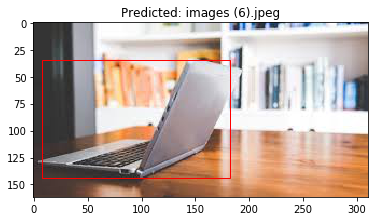

1 router [  67  454  875 1458] 0.99900144
4 laptop [179  25 465 467] 0.98476243


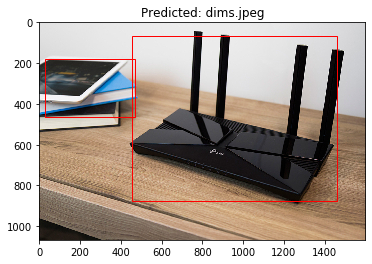

1 router [ 45  14 166 167] 0.99657404


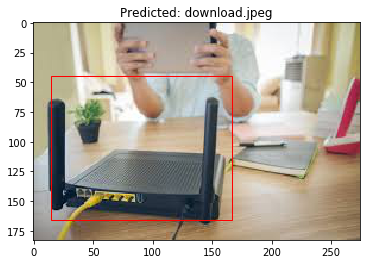

4 laptop [ 540  461 1018  832] 0.9541535
1 router [ 12  43 570 717] 0.8186944


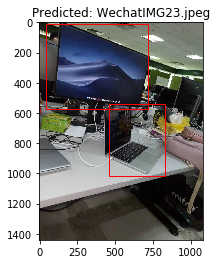

3 tv [ 31  93 104 181] 0.9965216
1 router [  6 188  33 229] 0.9457191


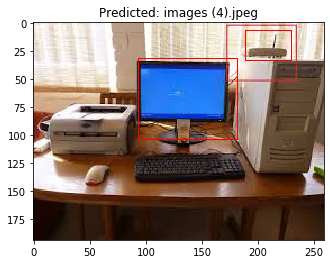

2 ceiling fan [  1  81  41 172] 0.9960757


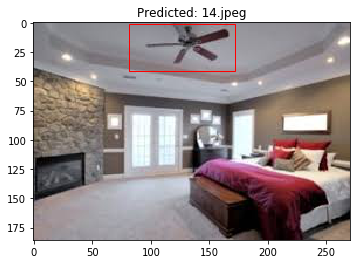

1 router [ 31  46 200 208] 0.9282467


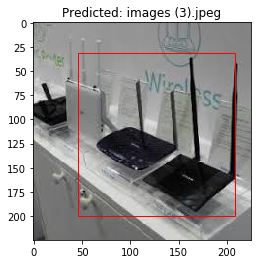

2 ceiling fan [ 27  74 165 298] 0.99314135


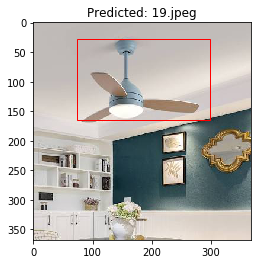

4 laptop [ 37  83 148 243] 0.99941874
4 laptop [ 86  60 129 118] 0.8913571


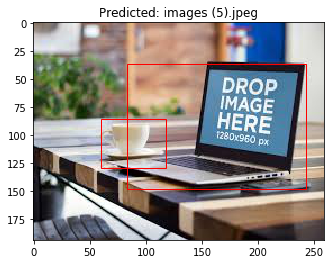

2 ceiling fan [ 13 119  41 182] 0.99101627


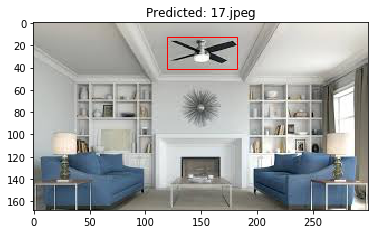

1 router [ 63  28 172 180] 0.99933726


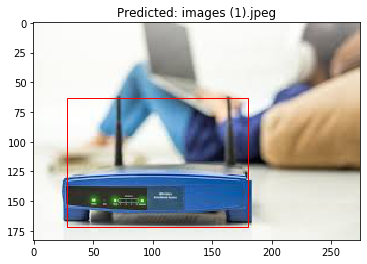

4 laptop [  8  65  97 210] 0.9290525
1 router [  0  49  89 196] 0.8317032


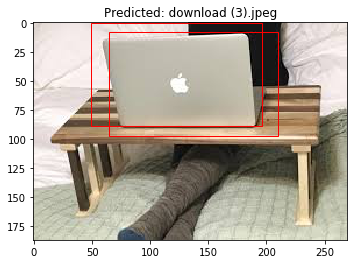

3 tv [363 266 918 930] 0.9455915


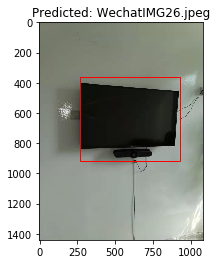

4 laptop [ 496  510  982 1124] 0.99888545
3 tv [119 129 620 915] 0.80740047


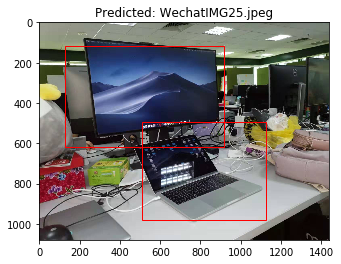

2 ceiling fan [ 10  54  81 177] 0.9576031


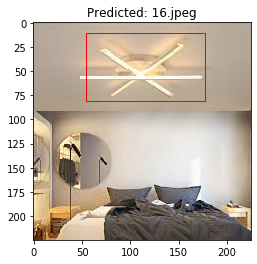

4 laptop [ 60  40 161 164] 0.9888994


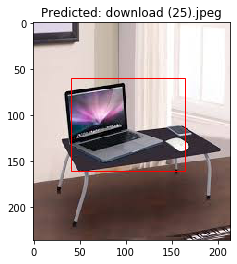

2 ceiling fan [  2  48  55 166] 0.9951108


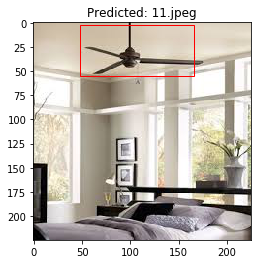

2 ceiling fan [  3  53  40 142] 0.98709226


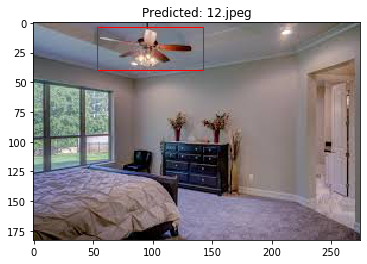

4 laptop [ 28  28 144 226] 0.9978573


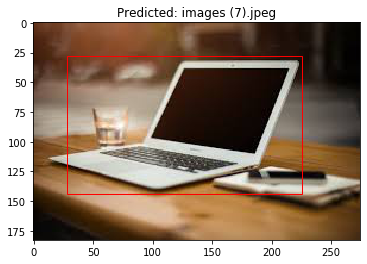

4 laptop [ 700  438 1312  934] 0.99600536
1 router [155  34 711 821] 0.7795377


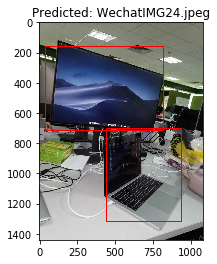

2 ceiling fan [  7  50  57 135] 0.9975587


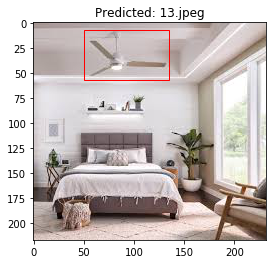

2 ceiling fan [  1  94  40 175] 0.99806935


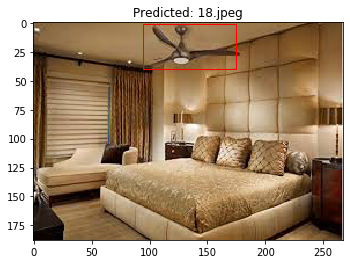

2 ceiling fan [ 53  55  86 140] 0.99867576
3 tv [ 97  86 136 136] 0.9810647


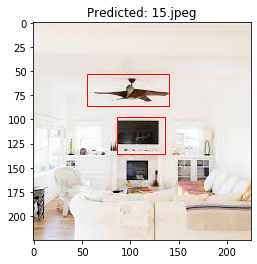

1 router [ 50  28 134 117] 0.8830851


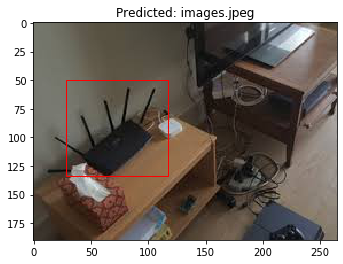

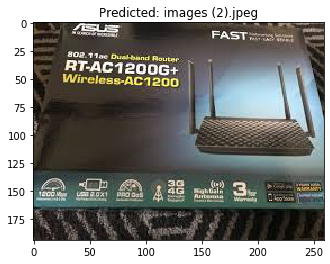

4 laptop [ 24  36 115 174] 0.99901545


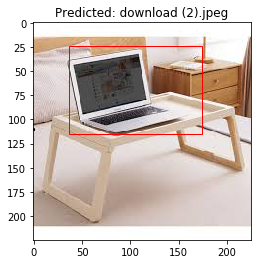

1 router [ 14  58 168 284] 0.9790854


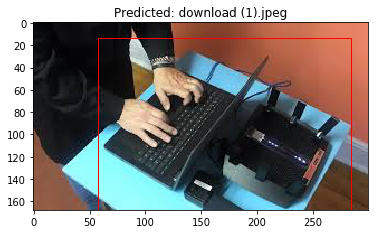

In [58]:
thres = 0.

for img_name in all_imgs_dict.keys():
    image = all_imgs_dict[img_name]['img']
    pred = all_imgs_dict[img_name]['pred']
    plt.imshow(image)
    ax = plt.gca()
    # plot each box
    for box, scr, mask, cls in zip(pred['rois'], pred['scores'], pred['masks'], pred['class_ids']):
        if scr > thres:     
            # get coordinates
            y1, x1, y2, x2 = box
            print(cls, class_name_dict[cls], box, scr)
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
            # plot mask
            #plt.imshow(mask, cmap='gray', alpha=0.3)
    plt.title('Predicted: {}'.format(img_name))
    plt.savefig('result.png')

In [ ]:
image_id=0
# load image, bounding boxes and masks for the image id
image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(
    testset, cfg, image_id, use_mini_mask=False)

# convert pixel values (e.g. center)
scaled_image = mold_image(image, cfg)

sample = np.expand_dims(scaled_image, 0)
# make prediction
yhat = model.detect(sample, verbose=0)
# extract results for first sample
r = yhat[0]

# calculate statistics, including AP
AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = np.expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = np.mean(APs)
    return mAP

train_mAP = evaluate_model(trainset, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(testset, model, cfg)
print("Test mAP: %.3f" % test_mAP)
